In [1]:
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(1004)   # for reproducibility
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline
from scipy.misc import imresize

import pandas as pd
import h5py
from scipy import stats
from lasagne import layers, nonlinearities, updates, objectives, init, regularization
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano

from six.moves import cPickle

from theano.tensor.shared_randomstreams import RandomStreams
import lasagne as nn
from lasagne import layers, init, nonlinearities, utils, regularization, objectives, updates
from lasagne.layers.base import Layer

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:


class BatchNormLayer(Layer):
    def __init__(self, incoming, axes='auto', epsilon=1e-4, alpha=0.1,
                 beta=init.Constant(0), gamma=init.Constant(1),
                 mean=init.Constant(0), inv_std=init.Constant(1), **kwargs):
        super(BatchNormLayer, self).__init__(incoming, **kwargs)

        if axes == 'auto':
            # default: normalize over all but the second axis
            axes = (0,) + tuple(range(2, len(self.input_shape)))
        elif isinstance(axes, int):
            axes = (axes,)
        self.axes = axes

        self.epsilon = utils.floatX(epsilon)
        self.alpha = utils.floatX(alpha)

        # create parameters, ignoring all dimensions in axes
        shape = [size for axis, size in enumerate(self.input_shape)
                 if axis not in self.axes]
        if any(size is None for size in shape):
            raise ValueError("BatchNormLayer needs specified input sizes for "
                             "all axes not normalized over.")
        if beta is None:
            self.beta = None
        else:
            self.beta = self.add_param(beta, shape, 'beta',
                                       trainable=True, regularizable=False)
        if gamma is None:
            self.gamma = None
        else:
            self.gamma = self.add_param(gamma, shape, 'gamma',
                                        trainable=True, regularizable=False)
        self.mean = self.add_param(mean, shape, 'mean',
                                   trainable=False, regularizable=False)
        self.inv_std = self.add_param(inv_std, shape, 'inv_std',
                                      trainable=False, regularizable=False)

        self.beta = T.cast(self.beta, dtype='floatX')
        self.gamma = T.cast(self.gamma, dtype='floatX')
        self.mean = T.cast(self.mean, dtype='floatX')
        self.inv_std = T.cast(self.inv_std, dtype='floatX')

    def get_output_for(self, input, deterministic=False,
                       batch_norm_use_averages=None,
                       batch_norm_update_averages=None, **kwargs):
        input_mean = input.mean(self.axes)
        input_inv_std = T.inv(T.sqrt(input.var(self.axes) + self.epsilon))

        # Decide whether to use the stored averages or mini-batch statistics
        if batch_norm_use_averages is None:
            batch_norm_use_averages = deterministic
        use_averages = batch_norm_use_averages

        if use_averages:
            mean = self.mean
            inv_std = self.inv_std
        else:
            mean = input_mean
            inv_std = input_inv_std

        # Decide whether to update the stored averages
        if batch_norm_update_averages is None:
            batch_norm_update_averages = not deterministic
        update_averages = batch_norm_update_averages

        if update_averages:
            # Trick: To update the stored statistics, we create memory-aliased
            # clones of the stored statistics:
            running_mean = theano.clone(self.mean, share_inputs=False)
            running_inv_std = theano.clone(self.inv_std, share_inputs=False)
            # set a default update for them:
            running_mean.default_update = ((1 - self.alpha) * running_mean +
                                           self.alpha * input_mean)
            running_inv_std.default_update = ((1 - self.alpha) *
                                              running_inv_std +
                                              self.alpha * input_inv_std)
            # and make sure they end up in the graph without participating in
            # the computation (this way their default_update will be collected
            # and applied, but the computation will be optimized away):
            mean += 0 * running_mean
            inv_std += 0 * running_inv_std

        # prepare dimshuffle pattern inserting broadcastable axes as needed
        param_axes = iter(range(input.ndim - len(self.axes)))
        pattern = ['x' if input_axis in self.axes
                   else next(param_axes)
                   for input_axis in range(input.ndim)]

        # apply dimshuffle pattern to all parameters
        beta = 0 if self.beta is None else self.beta.dimshuffle(pattern)
        gamma = 1 if self.gamma is None else self.gamma.dimshuffle(pattern)
        mean = mean.dimshuffle(pattern)
        inv_std = inv_std.dimshuffle(pattern)

        # normalize
        normalized = (input - mean) * (gamma * inv_std) + beta
        return normalized

class GaussianSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(GaussianSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


def vae_model(input_var):
    net = {}
    net['input'] = layers.InputLayer(shape=(None, 970), input_var=input_var)

    # encode layer 1
    net['encode1'] = layers.DenseLayer(net['input'], num_units=3000, W=init.GlorotUniform(), 
                                      b=init.Constant(0.05), nonlinearity=None)
    net['encode1_norm'] = BatchNormLayer(net['encode1'])
    net['encode1_active'] = layers.NonlinearityLayer(net['encode1_norm'], nonlinearity=nonlinearities.rectify)
    net['encode1_dropout'] = layers.DropoutLayer(net['encode1_active'],p=0.5)

    # encode layer
    net['Z_mu'] = layers.DenseLayer(net['encode1_dropout'], num_units=11350, W=init.GlorotUniform(), 
                                      b=init.Constant(0.05), nonlinearity=nonlinearities.linear)
    
    net['Z_logsigma'] = layers.DenseLayer(net['encode1_dropout'], num_units=11350, W=init.GlorotUniform(), 
                                      b=init.Constant(0.05), nonlinearity=nonlinearities.linear)
    net['Z'] = GaussianSampleLayer(net['Z_mu'], net['Z_logsigma'])

    # encode layer 1
    net['decode1'] = layers.DenseLayer(net['Z'], num_units=3000, W=init.GlorotUniform(), 
                                      b=init.Constant(0.05), nonlinearity=None)
    net['decode1_norm'] = BatchNormLayer(net['decode1'])
    net['decode1_active'] = layers.NonlinearityLayer(net['decode1_norm'], nonlinearity=nonlinearities.rectify)
    net['decode1_dropout'] = layers.DropoutLayer(net['decode1_active'],p=0.5)


    # encode layer
    net['X_mu'] = layers.DenseLayer(net['decode1_dropout'], num_units=970, W=init.GlorotUniform(), 
                                      b=init.Constant(0.05), nonlinearity=nonlinearities.linear)
    net['X_logsigma'] = layers.DenseLayer(net['decode1_dropout'], num_units=970, W=init.GlorotUniform(), 
                                      b=init.Constant(0.05), nonlinearity=nonlinearities.linear)
    net['X'] = GaussianSampleLayer(net['X_mu'], net['X_logsigma'])
    return net

In [63]:
def model_prediction(best_path, landmark, mean_nonlandmark, std_nonlandmark):
    class MultiplicativeGatingLayer(nn.layers.MergeLayer):
        """
        Generic layer that combines its 3 inputs t, h1, h2 as follows:
        y = t * h1 + (1 - t) * h2
        """
        def __init__(self, gate, input1, input2, **kwargs):
            incomings = [gate, input1, input2]
            super(MultiplicativeGatingLayer, self).__init__(incomings, **kwargs)
            assert gate.output_shape == input1.output_shape == input2.output_shape

        def get_output_shape_for(self, input_shapes):
            return input_shapes[0]

        def get_output_for(self, inputs, **kwargs):
            return inputs[0] * inputs[1] + (1 - inputs[0]) * inputs[2]
    def mlp_model(input_var):
        net = {}
        net['input'] = layers.InputLayer(shape=(None, 970), input_var=input_var)

        # encode layer 1
        net['encode1'] = layers.DenseLayer(net['input'], num_units=1000, W=init.GlorotUniform(), 
                                          b=init.Constant(0.05), nonlinearity=None)
        net['encode1_norm'] = BatchNormLayer(net['encode1'])
        net['encode1_active'] = layers.NonlinearityLayer(net['encode1_norm'], nonlinearity=nonlinearities.rectify)
        net['encode1_dropout'] = layers.DropoutLayer(net['encode1_active'],p=0.5)

        # encode layer 2
        net['encode2'] = layers.DenseLayer(net['encode1_dropout'], num_units=3000, W=init.GlorotUniform(), 
                                          b=init.Constant(0.05), nonlinearity=None)
        net['encode2_norm'] = BatchNormLayer(net['encode2'])
        net['encode2_active'] = layers.NonlinearityLayer(net['encode2_norm'], nonlinearity=nonlinearities.rectify)
        net['encode2_dropout'] = layers.DropoutLayer(net['encode2_active'],p=0.5)

        # encode layer
        net['output'] = layers.DenseLayer(net['encode2_dropout'], num_units=11350, W=init.GlorotUniform(), 
                                          b=init.Constant(0.05), nonlinearity=nonlinearities.linear)
        return net
    def dae_model(input_var):
        net = {}
        net['input'] = layers.InputLayer(shape=(None, 970), input_var=input_var)

        # encode layer 1
        net['encode1'] = layers.DenseLayer(net['input'], num_units=1000, W=init.GlorotUniform(), 
                                          b=init.Constant(0.05), nonlinearity=None)
        net['encode1_norm'] = BatchNormLayer(net['encode1'])
        net['encode1_active'] = layers.NonlinearityLayer(net['encode1_norm'], nonlinearity=nonlinearities.rectify)
        net['encode1_dropout'] = layers.DropoutLayer(net['encode1_active'],p=0.5)

        # encode layer 2
        net['encode2'] = layers.DenseLayer(net['encode1_dropout'], num_units=2000, W=init.GlorotUniform(), 
                                          b=init.Constant(0.05), nonlinearity=None)
        net['encode2_norm'] = BatchNormLayer(net['encode2'])
        net['encode2_active'] = layers.NonlinearityLayer(net['encode2_norm'], nonlinearity=nonlinearities.rectify)
        net['encode2_dropout'] = layers.DropoutLayer(net['encode2_active'],p=0.5)

        # encode layer 2
        net['encode3'] = layers.DenseLayer(net['encode2_dropout'], num_units=3000, W=init.GlorotUniform(), 
                                          b=init.Constant(0.05), nonlinearity=None)
        net['encode3_norm'] = BatchNormLayer(net['encode3'])
        net['encode3_active'] = layers.NonlinearityLayer(net['encode3_norm'], nonlinearity=nonlinearities.rectify)
        net['encode3_dropout'] = layers.DropoutLayer(net['encode3_active'],p=0.5)

        # encode layer
        net['encode'] = layers.DenseLayer(net['encode3_dropout'], num_units=11350, W=init.GlorotUniform(), 
                                          b=init.Constant(0.05), nonlinearity=None)
        net['output'] = layers.NonlinearityLayer(net['encode'], nonlinearity=nonlinearities.linear)
        return net

    def highway_dense(incoming, Wh=init.Orthogonal(), bh=init.Constant(0.0),
                      Wt=init.Orthogonal(), bt=init.Constant(-4.0),
                      nonlinearity=nonlinearities.rectify, **kwargs):
        num_inputs = int(np.prod(incoming.output_shape[1:]))
        # regular layer
        l_h = layers.DenseLayer(incoming, num_units=num_inputs, W=Wh, b=bh,
                                   nonlinearity=nonlinearity)
        # gate layer
        l_t = layers.DenseLayer(incoming, num_units=num_inputs, W=Wt, b=bt,
                                   nonlinearity=T.nnet.sigmoid)

        return MultiplicativeGatingLayer(gate=l_t, input1=l_h, input2=incoming)

    def build_model(input_var, batch_size=100,
                    num_hidden_units=500, num_hidden_layers=50):

        l_in = layers.InputLayer(shape=(batch_size, 970), input_var=input_var)

        # first, project it down to the desired number of units per layer
        l_hidden1 = layers.DenseLayer(l_in, num_units=num_hidden_units)

        # then stack highway layers on top of this
        l_current = l_hidden1
        for k in range(num_hidden_layers - 1):
            l_current = highway_dense(l_current)


        l_hidden2 = layers.DenseLayer(l_current, num_units=2000)

        # finally add an output layer
        l_out = layers.DenseLayer( l_hidden2, num_units=11350, nonlinearity=nonlinearities.linear)

        return l_out


    # setup model
    input_var = T.dmatrix('landmark')
    #network = build_model(input_var, batch_size=100, num_hidden_units=500, num_hidden_layers=50)
    #network = build_model(input_var)
    network = build_model(input_var)
    
    f = open(best_path, 'rb')
    best_parameters = cPickle.load(f)
    f.close()
    layers.set_all_param_values(network, best_parameters)


    prediction = layers.get_output(network, deterministic=True)

    get_prediction = theano.function([input_var], prediction, allow_input_downcast=True)
    prediction = get_prediction(landmark)

    prediction = prediction.transpose([1,0]).astype(np.float64)
    num_samples = prediction.shape[1]
    prediction = (prediction*std_nonlandmark) + mean_nonlandmark
    return prediction

In [64]:
landmarkpath='/home/peter/Data/CMAP/test/landmarks.csv'
data = pd.read_csv(landmarkpath, header=None, dtype=np.float32)
landmark = data.as_matrix()

nonlandmarkpath='/home/peter/Data/CMAP/test/truth.csv'
data = pd.read_csv(nonlandmarkpath, header=None, dtype=np.float32)
nonlandmark = data.as_matrix()

def normalize_data(landmark, mean_landmark, std_landmark, num_samples):
    landmark = (landmark - mean_landmark)/std_landmark
    landmark = landmark.transpose([1,0])
    return landmark
print landmark.shape
mean_landmark = np.mean(landmark)
std_landmark = np.std(landmark)
landmark = normalize_data(landmark, mean_landmark, std_landmark, landmark.shape[1])

(970, 1000)


In [65]:
best_path = '/home/peter/Data/CMAP/Results/highway_corr2epoch_3.pickle'
prediction = model_prediction(best_path, landmark,  mean_landmark, std_landmark)

df2 = pd.DataFrame(prediction)
df2.to_csv('/home/peter/Data/CMAP/test/prediction_ff.csv', header=None, index=False)

In [66]:
path='/home/peter/Data/CMAP/test/prediction_ff.csv'
data = pd.read_csv(path, header=None, dtype=np.float32)
test = data.as_matrix()
test.shape

nonlandmarkpath='/home/peter/Data/CMAP/test/truth.csv'
data = pd.read_csv(nonlandmarkpath, header=None, dtype=np.float32)
truth = data.as_matrix()
truth.shape

R = []
for i in range(prediction.shape[1]):
    R.append(stats.spearmanr(prediction[i,:], truth[i,:])[0])
np.mean(R)

0.77851194316691108

(array([   2.,    0.,    1.,    0.,    2.,    3.,    8.,    8.,   10.,
          11.,   19.,   13.,   18.,   11.,   17.,   26.,   23.,   21.,
          25.,   19.,   35.,   31.,   50.,   66.,   87.,  124.,  158.,
         120.,   72.,   20.]),
 array([ 0.17687296,  0.20330537,  0.22973778,  0.25617019,  0.28260261,
         0.30903502,  0.33546743,  0.36189984,  0.38833225,  0.41476467,
         0.44119708,  0.46762949,  0.4940619 ,  0.52049431,  0.54692672,
         0.57335914,  0.59979155,  0.62622396,  0.65265637,  0.67908878,
         0.7055212 ,  0.73195361,  0.75838602,  0.78481843,  0.81125084,
         0.83768326,  0.86411567,  0.89054808,  0.91698049,  0.9434129 ,
         0.96984532]),
 <a list of 30 Patch objects>)

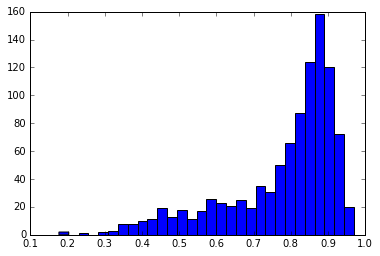

In [67]:
plt.hist(R,bins=30)

In [ ]:
"""
Rscript cmap_scoring_function.R --inf_ds prediction_ff.csv \
     --truth_ds truth.csv \
     --reference_scores refScores.csv \
     --out here


java ConnectivityMap prediction_ff.csv truth.csv refScores.csv



# submission

In [61]:
landmarkpath='/home/peter/Data/CMAP/test/testData.csv'
data = pd.read_csv(landmarkpath, header=None, dtype=np.float32)
landmark = data.as_matrix()


def normalize_data(landmark, mean_landmark, std_landmark, num_samples):
    landmark = (landmark - mean_landmark)/std_landmark
    landmark = landmark.transpose([1,0])
    return landmark

mean_landmark = np.mean(landmark)
std_landmark = np.std(landmark)
landmark = normalize_data(landmark, mean_landmark, std_landmark, landmark.shape[1])

In [62]:

best_path = '/home/peter/Data/CMAP/Results/highway_corr2epoch_3.pickle'
prediction = model_prediction(best_path, landmark, mean_landmark, std_landmark)

filename = 'submission2.csv'
df2 = pd.DataFrame(prediction)
df2.to_csv('/home/peter/Data/CMAP/test/'+filename, header=None, index=False)


In [ ]:
prediction.shape
